${\Large \textbf{C1: SSH from VarDyn in the Lofoten Basin Eddy}}$  
In this notebook, we plot the SSH in the LBE using VarDyn product, and the associated geostrophic currents

In [1]:
import xarray as xr
import shapefile as shp 
import numpy as np
import matplotlib.pyplot as plt
import SWOT_tools as st
import pandas as pd
from shapely.geometry import box
from shapely.wkt import loads  # In case your polygons are stored as WKT strings
import scipy 
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches
from datetime import datetime
from tqdm import tqdm
import os

In [2]:
import matplotlib.font_manager as fm
# Regular and bold font paths
font_regular_path = "fonts/times/times.ttf"
font_bold_path = "fonts/times/timesbd.ttf"  # Bold
# Register both fonts
fm.fontManager.addfont(font_regular_path)
fm.fontManager.addfont(font_bold_path)
# Create font properties
font_regular = fm.FontProperties(fname=font_regular_path)
font_bold = fm.FontProperties(fname=font_bold_path)
# Set default font to regular Times New Roman
plt.rcParams['font.family'] = font_regular.get_name()

dx (km): 467.81, dy (km): 556.59, scale: 1.19


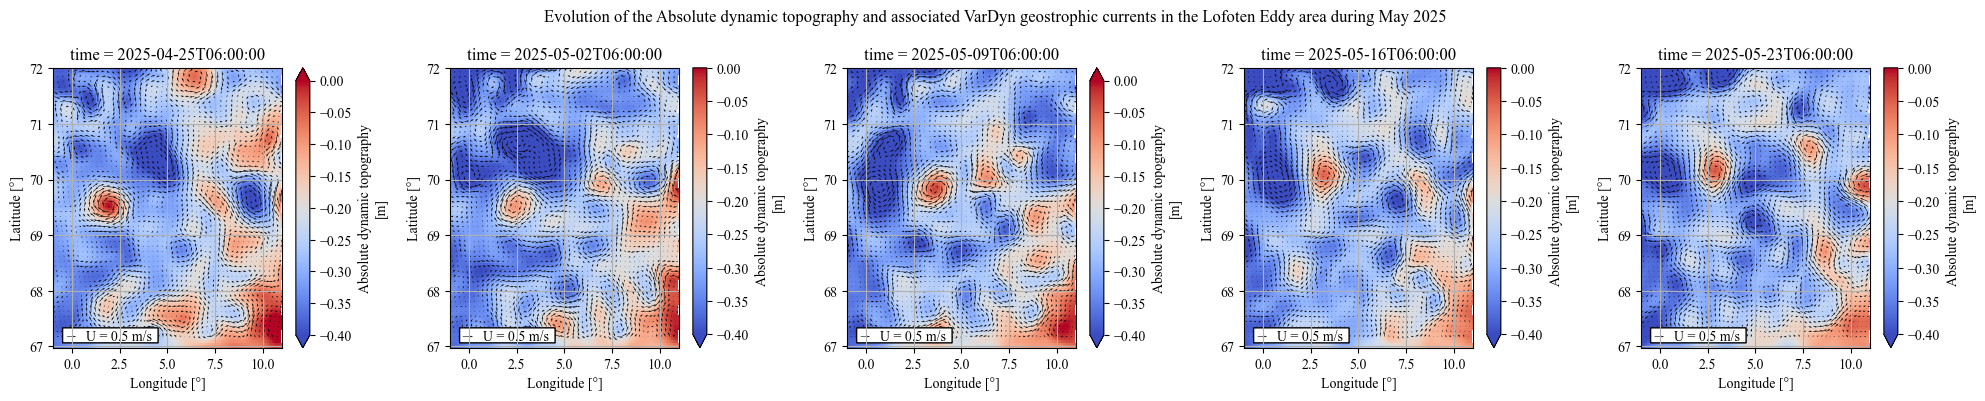

In [3]:
ds_vardyn = xr.open_dataset(r"data/vardyn/2025/129/VarDyn_Lofoten_SWOT_allNadirs.nc")

lon_map_min, lon_map_max, lat_map_min, lat_map_max = -1, 11, 67, 72
Rt = 6378  # km
mean_lat_rad = np.radians((lat_map_min + lat_map_max)/2)
dx = Rt * np.cos(mean_lat_rad) * np.radians(lon_map_max - lon_map_min)
dy = Rt * np.radians(lat_map_max - lat_map_min)
scale_fact = dy / dx

print(f"dx (km): {dx:.2f}, dy (km): {dy:.2f}, scale: {scale_fact:.2f}")

# Full figure size
Lx = 4  # inches
Ly = Lx * scale_fact

show_vardyn = True
fig, ax = plt.subplots(1,5, figsize=(5*Lx,0.85*Ly))
times = [97, 125]+[153 + k*28 for k in range(3)]#+ [236]

omega_T = 7.292115e-5 # rad/s
g = 9.81 # m.s-2

for i, time in enumerate(times):
    ds = ds_vardyn.isel(time=time)
    ds = ds.where((ds.lon >= lon_map_min) & (ds.lon <= lon_map_max) & (ds.lat>= lat_map_min) & (ds.lat <= lat_map_max), drop=True)
    X_vd_grid = ds.lon.values # shape (113, 175)
    Y_vd_grid = ds.lat.values # shape (113, 175)
    u_vd = ds.u
    v_vd = ds.v
    norm_U_vd = 100*np.sqrt(u_vd**2 + v_vd**2) 

    max_mag_vd = np.nanmax(norm_U_vd)
    arrow_length = 1.5*3.62
    scale_vd = max_mag_vd / arrow_length

    f_along_track = 2*omega_T*np.sin(Y_vd_grid)[:-1:,:-1:]

    ssh = ds.ssh.values
    u_geos = - g / f_along_track * (ssh[1::,1::] - ssh[:-1:,1::])/(Rt*np.radians(Y_vd_grid[1::,1::] - Y_vd_grid[:-1:,1::]))
    v_geos = g / f_along_track * (ssh[1::,1::] - ssh[1::,:-1:])/(Rt*np.cos(np.radians(Y_vd_grid[1::,1::]))*np.radians(X_vd_grid[1::,1::] - X_vd_grid[1::,:-1:]))

    
    ds.ssh.plot(x="lon", y="lat", ax=ax[i],vmin=-0.4, vmax=0,cmap="coolwarm")


    X_geos_grid, Y_geos_grid = X_vd_grid[:-1:,:-1:], Y_vd_grid[:-1:,:-1:]
    if show_vardyn:
        step_vd = 2
        #qvd = ax[i].quiver(X_geos_grid[2*step_vd::step_vd,::step_vd], Y_geos_grid[2*step_vd::step_vd,::step_vd], u_geos[2*step_vd::step_vd,::step_vd], v_geos[2*step_vd::step_vd,::step_vd], color="black", label="Geos")
        #ax[i].pcolormesh(X_vd_grid, Y_vd_grid, np.sqrt(u_vd**2 + v_vd**2))
        qvd = ax[i].quiver(X_vd_grid[2*step_vd::step_vd,::step_vd], Y_vd_grid[2*step_vd::step_vd,::step_vd], u_vd[2*step_vd::step_vd,::step_vd], v_vd[2*step_vd::step_vd,::step_vd], color="black", label="Vardyn Direction", scale=scale_vd)
        # Add a quiver key to indicate vector scale
        ax[i].set_xlabel("Longitude [°]")
        ax[i].set_ylabel("Latitude [°]")
    
    ax[i].set_xlim(-1,11)
    ax[i].grid()

    # Add fixed size white rectangle
    rect = patches.FancyBboxPatch(
        (-0.5, 67.075),  # bottom left corner in data coords
        width=5, height=0.25, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
    ax[i].add_patch(rect)

    if show_vardyn:
       ax[i].quiverkey(qvd, X=0.10, Y=0.04, U=0.5,label='U = 0.5 m/s ', labelpos='E')

plt.suptitle("Evolution of the Absolute dynamic topography and associated VarDyn geostrophic currents in the Lofoten Eddy area during May 2025")
plt.tight_layout()
plt.savefig("output_images/LF/ADT_LF.png")

In [4]:
# Small piece of code to check that the current displayed is indeed geostrophic current (we compute it by ourselves using la ssh disponible)

/dev/shm/pbs.3818094.datarmor0/ipykernel_16957/2014897829.py:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X_plot, Y_plot, speed, shading='auto')


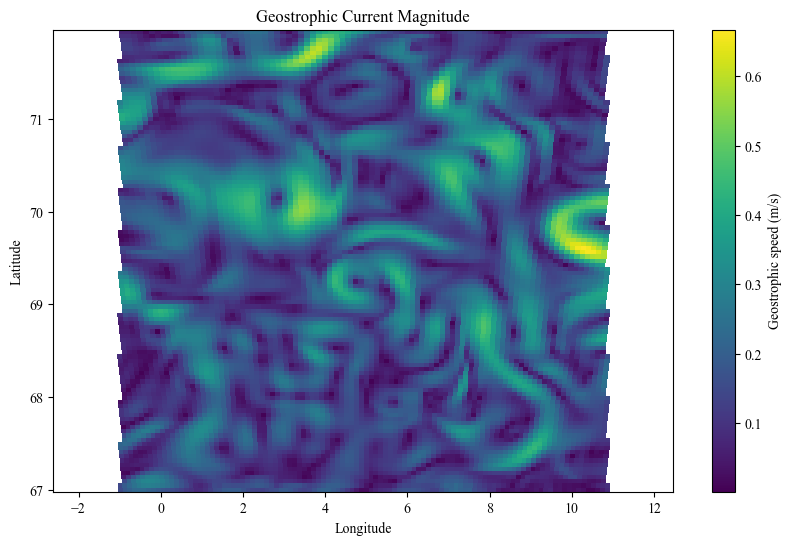

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
omega_T = 7.292115e-5  # rad/s
g = 9.81               # m/s^2
Rt = 6371000           # Earth radius in meters

# Grids
X_vd_grid = ds.lon.values  # shape (ny, nx)
Y_vd_grid = ds.lat.values

# Coriolis parameter
f = 2 * omega_T * np.sin(np.radians(Y_vd_grid))  # shape (ny, nx)

# SSH field
ssh = ds.ssh.values  # shape (ny, nx)

# Calculate dSSH/dy and dSSH/dx
# dy (meridional distance between latitudes)
dy = Rt * np.radians(Y_vd_grid[1:, :] - Y_vd_grid[:-1, :])
dssh_dy = (ssh[1:, :] - ssh[:-1, :]) / dy

# dx (zonal distance between longitudes, adjusted by cos(lat))
lat_mid = 0.5 * (Y_vd_grid[:, 1:] + Y_vd_grid[:, :-1])
dx = Rt * np.cos(np.radians(lat_mid)) * np.radians(X_vd_grid[:, 1:] - X_vd_grid[:, :-1])
dssh_dx = (ssh[:, 1:] - ssh[:, :-1]) / dx

# Trim f to match derivative shapes
f_v = f[:-1, :]     # for v component
f_u = f[:, :-1]     # for u component

# Geostrophic components
u_geos = -g / f_v * dssh_dy  # shape (ny-1, nx)
v_geos =  g / f_u * dssh_dx  # shape (ny, nx-1)

# Get matching grid positions for plotting
X_u = X_vd_grid[:-1, :]  # shape (ny-1, nx)
Y_u = Y_vd_grid[:-1, :]

X_v = X_vd_grid[:, :-1]  # shape (ny, nx-1)
Y_v = Y_vd_grid[:, :-1]

# Compute speed on intersection grid
speed = np.sqrt(u_geos[:, :-1]**2 + v_geos[:-1, :]**2)

# Matching grid for plotting
X_plot = X_vd_grid[:-1, :-1]
Y_plot = Y_vd_grid[:-1, :-1]

# Plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(X_plot, Y_plot, speed, shading='auto')
plt.colorbar(label='Geostrophic speed (m/s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geostrophic Current Magnitude')
plt.show()


In [51]:
ds_vardyn.u

<xarray.DataArray 'u' (time: 237, y: 113, x: 175)> Size: 37MB
[4686675 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2025-04-01 ... 2025-05-30
    lon      (y, x) float64 158kB -5.0 -4.885 -4.77 -4.655 ... 17.38 17.52 17.67
    lat      (y, x) float64 158kB 67.0 67.0 67.0 67.0 ... 72.03 72.03 72.03
Dimensions without coordinates: y, x
Attributes:
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    units:          m/s

In [29]:
ds_vardyn.time

<xarray.DataArray 'time' (time: 237)> Size: 2kB
array(['2025-04-01T00:00:00.000000000', '2025-04-01T06:00:00.000000000',
       '2025-04-01T12:00:00.000000000', ..., '2025-05-29T12:00:00.000000000',
       '2025-05-29T18:00:00.000000000', '2025-05-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2025-04-01 ... 2025-05-30

In [11]:
ds_vardyn.ssh

<xarray.DataArray 'ssh' (time: 237, y: 113, x: 175)> Size: 37MB
[4686675 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2025-04-01 ... 2025-05-30
    lon      (y, x) float64 158kB ...
    lat      (y, x) float64 158kB ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:  sea_surface_height_above_geoid
    units:          m
    long_name:      Absolute dynamic topography